In [ ]:
import pandas as pd
import numpy as np
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import os
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
files = os.path.join('/content/drive/MyDrive/Twitter Depression Dataset/*.csv')

In [ ]:
files = glob.glob(files)

In [ ]:
files

['/content/drive/MyDrive/Twitter Depression Dataset/twitterdepresi_augmented.csv',
 '/content/drive/MyDrive/Twitter Depression Dataset/Twitterdepresi(label_0) (1).csv']

In [ ]:
data = pd.concat(map(pd.read_csv, files), ignore_index=True)
data.head()

,text,label
0,khawatir khawatir dengan gelisah,1.0
1,Bulan Kalender benar -benar kesalahan bodoh se...,1.0
2,Aku mual,1.0
3,Tahan tidur dengan gelisah duduk dengan gelisa...,1.0
4,Tolong sangat cemas cemas,1.0


In [ ]:
data.text = data.text.astype(str)

In [ ]:
data['label'].value_counts()

1.0    8257
0.0    8104
Name: label, dtype: int64

In [ ]:
text = data['text']
label = data['label']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(text)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=40, padding='post')
    return padded_sequences

In [ ]:
padded_train_sequences = get_sequences(tokenizer, text)

In [ ]:
classes = set(label)
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())
names_to_ids_training= lambda labels: np.array([classes_to_index.get(x) for x in label])
labels = names_to_ids_training(label)

In [ ]:

from sklearn.model_selection import train_test_split

# Split training data to train and validation set
x_train, x_valid, y_train, y_valid = train_test_split(padded_train_sequences, labels, test_size=0.2, shuffle= True, random_state=10)

In [ ]:
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(13088, 40)
(3273, 40)
(13088,)
(3273,)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=40),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(
    optimizer=Adam(learning_rate = 1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 40)          400000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                26880     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 443,586
Trainable params: 443,586
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h = model.fit(
    x_train, y_train, batch_size=32, epochs=100, validation_split=0.2
)

Epoch 1/100
328/328 [==============================] - 10s 22ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5061
Epoch 2/100
328/328 [==============================] - 8s 24ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6931 - val_accuracy: 0.5057
Epoch 3/100
328/328 [==============================] - 7s 21ms/step - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6930 - val_accuracy: 0.5065
Epoch 4/100
328/328 [==============================] - 8s 24ms/step - loss: 0.6929 - accuracy: 0.5047 - val_loss: 0.6925 - val_accuracy: 0.5080
Epoch 5/100
328/328 [==============================] - 7s 22ms/step - loss: 0.6848 - accuracy: 0.6166 - val_loss: 0.6448 - val_accuracy: 0.8377
Epoch 6/100
328/328 [==============================] - 7s 22ms/step - loss: 0.3243 - accuracy: 0.9254 - val_loss: 0.1563 - val_accuracy: 0.9423
Epoch 7/100
328/328 [==============================] - 8s 23ms/step - loss: 0.1156 - accuracy: 0.9601 - val_loss: 0.1172 - val_accuracy

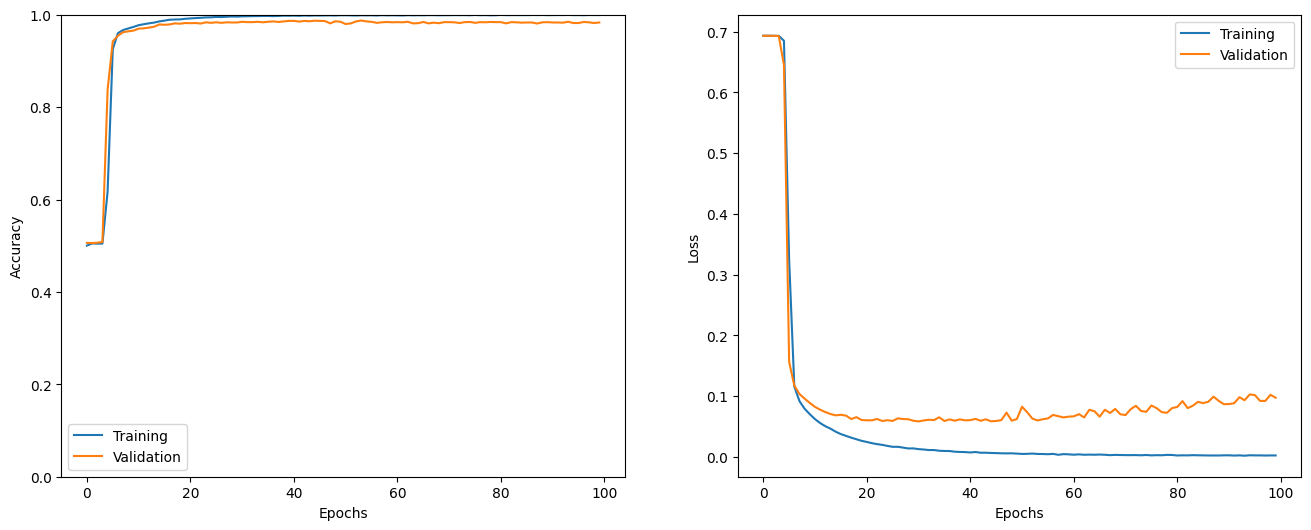

In [ ]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [ ]:
model.save_weights('/content/drive/MyDrive/Twitter Depression Dataset/Perbandingan/LSTM.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/Twitter Depression Dataset/Perbandingan/LSTM.h5')

In [ ]:
eval = model.evaluate(x_valid, y_valid)

103/103 [==============================] - 1s 6ms/step - loss: 0.1150 - accuracy: 0.9808


In [ ]:
preds = np.argmax(model.predict(x_valid), axis=1)
preds.shape, y_valid.shape

103/103 [==============================] - 1s 5ms/step


((3273,), (3273,))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_valid, preds)
print(cm)

[[1567   52]
 [  11 1643]]


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
report = classification_report(y_valid,preds)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1619
           1       0.97      0.99      0.98      1654

    accuracy                           0.98      3273
   macro avg       0.98      0.98      0.98      3273
weighted avg       0.98      0.98      0.98      3273



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_valid.round(),preds.round()).ravel()
Sensitivity = tp / (tp + fn)
print("Sensitivity: ", Sensitivity)
# Fraction of the true background that is correctly segmented
Specificity = tn / (tn + fp)
print("Specificity: ", Specificity)
# Fraction of the segmented object that is correctly segmented
Precision = tp / (tp + fp)
print("Precision: ", Precision)
# Fraction of the true object that is correctly segmented
Recall = tp / (tp + fn)
print("Recall: ", Recall)
# Harmonic mean ofprecision and recall
F_measure = 2 * (Recall * Precision) / (Recall + Precision)
print("F-measure: ", F_measure)
# Fraction of the union of the segmented object and the true object that is correctly segmented
JSC = tp / (fp + tp + fn)
print("Jaccardsimilarity coefficient: ", JSC)
# Fraction of the segmented object set joined with the true object set that is correctly segmented
DSC = 2 * tp / (fp + 2 * tp + fn)
print("Dice similarity coefficient: ", DSC)

Sensitivity:  0.9933494558645707
Specificity:  0.967881408276714
Precision:  0.9693215339233038
Recall:  0.9933494558645707
F-measure:  0.9811884144520752
Jaccardsimilarity coefficient:  0.963071512309496
Dice similarity coefficient:  0.9811884144520753


In [ ]:
#ROC
from sklearn.metrics import roc_curve, auc

preds = np.argmax(model.predict(x_valid), axis=1)

fpr, tpr, thresholds = roc_curve(y_valid.round(), preds.round())
auc_score = auc(fpr,tpr)

103/103 [==============================] - 1s 5ms/step


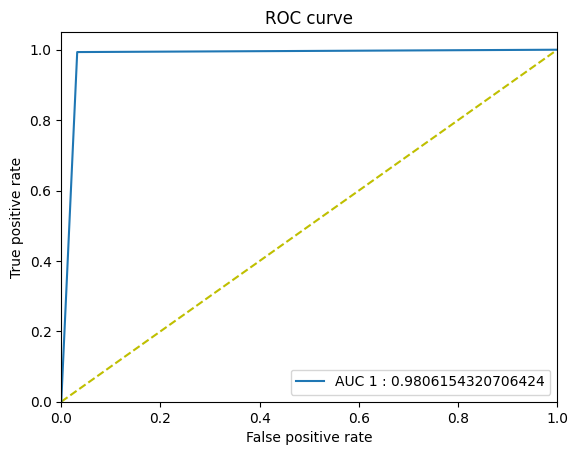

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(fpr, tpr, label = "AUC {} : {}".format(1, auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc=4)

Testing

In [ ]:
import random
for a in range(0,5):
  i = random.randint(0, len(y_valid) - 1)

  print('Tweet:', text[i])
  print('Actual Emotion:', index_to_classes[labels[i]])

  p = np.argmax(model.predict(np.expand_dims(x_valid[i], axis=0))[0])

  print('Predicted Emotion:', index_to_classes.get(p), '\n')